**Sentiment analysis is a natural language processing technique that identifies the polarity of a given text. There are different flavors of sentiment analysis, but one of the most widely used techniques labels data into positive and negative**

In [1]:
import pandas as pd
import numpy as np
import pickle
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import tkinter as tk
from tkinter import ttk
from contractions import fix


In [4]:
# Downloading necessary NLTK data
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jmoat\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jmoat\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jmoat\AppData\Roaming\nltk_data...


True

In [2]:
# Load data (assuming the file paths are correct)
file_path_train = 'train.tsv'
data_train = pd.read_csv(file_path_train, sep='\t', header=None)
data_train.columns = ['review', 'label']

file_path_test = 'test.tsv'
data_test = pd.read_csv(file_path_test, sep='\t', header=None)
data_test.columns = ['review', 'label']

file_path_test = 'dev.tsv'
data_dev = pd.read_csv(file_path_test, sep='\t', header=None)
data_dev.columns = ['review', 'label']

In [3]:
data=pd.concat([data_train,data_test,data_dev])
data

,review,label
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1
...,...,...
867,something like scrubbing the toilet,0
868,"smart , provocative and blisteringly funny",1
869,"this one is definitely one to skip , even for ...",0
870,charles ' entertaining film chronicles seinfel...,1


In [4]:
data.duplicated().sum()

11

In [5]:
data.drop_duplicates(inplace=True)

In [6]:
data.isnull().sum()

review    0
label     0
dtype: int64

C:\Users\jmoat\AppData\Local\Temp\ipykernel_5008\755530550.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data,palette="viridis")


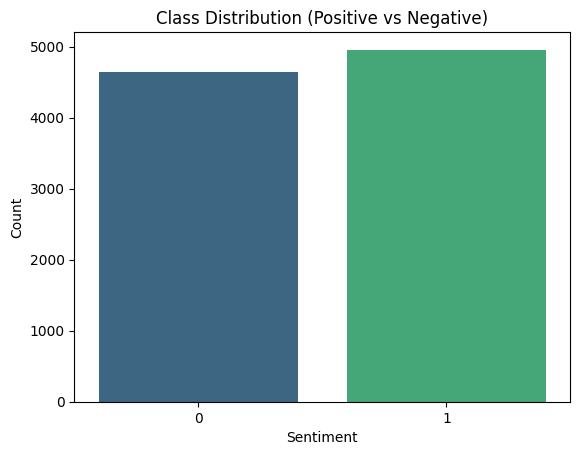

In [7]:
sns.countplot(x='label', data=data,palette="viridis")
plt.title('Class Distribution Data')
plt.title("Class Distribution (Positive vs Negative)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

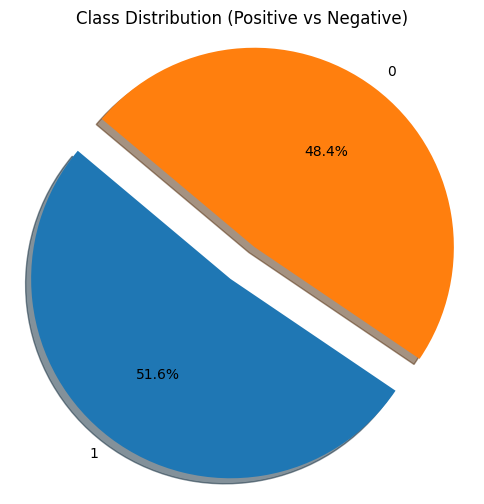

In [8]:
# Count the occurrences of each class label
class_counts = data['label'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))
myexplode = [0.2, 0]
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140,explode = myexplode,shadow = True)
plt.title("Class Distribution (Positive vs Negative)")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

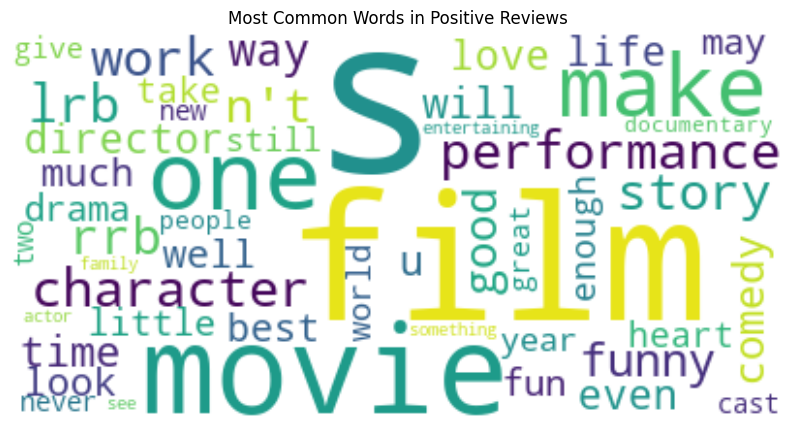

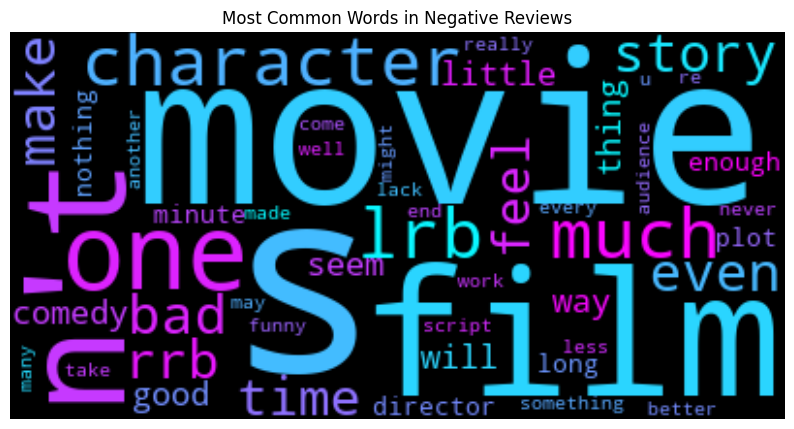

In [9]:
# Generate word clouds for positive and negative reviews
positive_text = " ".join(review for review in data[data['label'] == 1]['review'])
negative_text = " ".join(review for review in data[data['label'] == 0]['review'])

# Positive WordCloud
wordcloud_pos = WordCloud(background_color='white', max_words=50).generate(positive_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Positive Reviews")
plt.show()

# Negative WordCloud
wordcloud_neg = WordCloud(background_color='black', max_words=50, colormap='cool').generate(negative_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Negative Reviews")
plt.show()

In [10]:
# Define a function to clean each review
def clean_text(text):
    # Check if the text is a string before applying string operations
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()

        # Expand contractions (e.g., "can't" -> "cannot")
        text = fix(text)

        # Remove special characters, punctuation, and numbers using regex
        text = re.sub(r'[^a-z\s]', '', text)

        # Tokenize the text
        words = word_tokenize(text)

        # Remove stopwords and single-character tokens
        stop_words = set(stopwords.words('english'))

        # Custom stopwords (add "rrb", "lrb", and other irrelevant tokens)
        custom_stopwords = ['rrb', 'lrb', 'br','movie', 'one', 'character', 'make', 'time', 'story', 'film','nt']
        stop_words.update(custom_stopwords)

        # Remove stopwords and filter out words of length <= 1
        cleaned_words = [word for word in words if word not in stop_words and len(word) > 1]

        # Join the cleaned words back into a string
        cleaned_text = ' '.join(cleaned_words)

        return cleaned_text
    else:
        # Handle non-string values (e.g., return an empty string or NaN)
        return ''  # or you can return float('nan') if you prefer to keep NaNs

# Apply the cleaning function to the 'review' column
data['review'] = data['review'].apply(clean_text)

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\jmoat/nltk_data'
    - 'c:\\Users\\jmoat\\AppData\\Local\\Programs\\Python\\Python39\\nltk_data'
    - 'c:\\Users\\jmoat\\AppData\\Local\\Programs\\Python\\Python39\\share\\nltk_data'
    - 'c:\\Users\\jmoat\\AppData\\Local\\Programs\\Python\\Python39\\lib\\nltk_data'
    - 'C:\\Users\\jmoat\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [18]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return ' '.join(lemmatized_tokens)

In [19]:
data['review'] = data['review'].apply(preprocess_text)


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\jmoat/nltk_data'
    - 'c:\\Users\\jmoat\\AppData\\Local\\Programs\\Python\\Python39\\nltk_data'
    - 'c:\\Users\\jmoat\\AppData\\Local\\Programs\\Python\\Python39\\share\\nltk_data'
    - 'c:\\Users\\jmoat\\AppData\\Local\\Programs\\Python\\Python39\\lib\\nltk_data'
    - 'C:\\Users\\jmoat\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [13]:
data

,review,label
0,"stirring , funny finally transporting imaginin...",1
1,apparently reassembled cutting room floor give...,0
2,presume audience wo n't sit still sociology le...,0
3,"visually stunning rumination love , memory , h...",1
4,jonathan parker 's bartleby end modern office ...,1
...,...,...
867,something like scrubbing toilet,0
868,"smart , provocative blisteringly funny",1
869,"one definitely one skip , even horror movie fa...",0
870,charles ' entertaining film chronicle seinfeld...,1


In [14]:
# Split the data into train, test, and dev sets
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
data_train, data_dev = train_test_split(data_train, test_size=0.1, random_state=42)

In [15]:
# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=12491)
X_train_vectors = vectorizer.fit_transform(data_train['review'])
X_test_vectors = vectorizer.transform(data_test['review'])
X_dev_vectors = vectorizer.transform(data_dev['review'])

In [16]:
# Fit your vectorizer on training data
vectorizer = TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(data_train['review'])  # Assuming X_train is your preprocessed training data
# Save the vectorizer to a file
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)


In [17]:
y_train = np.array(data_train['label'])
y_test = np.array(data_test['label'])
y_dev=np.array(data_dev['label'])

In [18]:
from sklearn.svm import SVC  # Import the correct class

# Train the SVM classifier on the training data
svm_classifier = SVC(kernel='linear')  # Use SVC, not svm
svm_classifier.fit(X_train_vectors, y_train)

# Evaluate the model on the development set
y_dev_pred = svm_classifier.predict(X_dev_vectors)

# Calculate accuracy on the dev set

dev_accuracy = accuracy_score(y_dev, y_dev_pred)
print(f"Dev Set Accuracy: {dev_accuracy}")

# After tuning hyperparameters, evaluate on the test set
y_test_pred = svm_classifier.predict(X_test_vectors)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Set Accuracy: {test_accuracy}")

Dev Set Accuracy: 0.7737321196358907
Test Set Accuracy: 0.7933368037480479


In [19]:
# Predict the labels for the testing set
y_pred = svm_classifier.predict(X_test_vectors)
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       961
           1       0.78      0.81      0.80       960

    accuracy                           0.79      1921
   macro avg       0.79      0.79      0.79      1921
weighted avg       0.79      0.79      0.79      1921



In [20]:
logistic_classifier_model = LogisticRegression()
logistic_classifier_model.fit(X_train_vectors, y_train)
# Evaluate the model on the development set
y_dev_pred = logistic_classifier_model.predict(X_dev_vectors)
# Calculate accuracy on the dev set
dev_accuracy = accuracy_score(y_dev, y_dev_pred)
print(f"Dev Set Accuracy: {dev_accuracy}")
logistic_pred = logistic_classifier_model.predict(X_test_vectors)
logistic_report = classification_report(y_test, logistic_pred)

print("***** Logistic Regression *****")
print(logistic_report)

Dev Set Accuracy: 0.7737321196358907
***** Logistic Regression *****
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       961
           1       0.77      0.82      0.80       960

    accuracy                           0.79      1921
   macro avg       0.79      0.79      0.79      1921
weighted avg       0.79      0.79      0.79      1921



In [21]:
random_forest_model = RandomForestClassifier(criterion="gini", random_state=42)
random_forest_model.fit(X_train_vectors, y_train)
random_forest_pred = random_forest_model.predict(X_test_vectors)
random_forest_report = classification_report(y_test, random_forest_pred)

print("***** Random Forest *****")
print(random_forest_report)

***** Random Forest *****
              precision    recall  f1-score   support

           0       0.72      0.77      0.75       961
           1       0.75      0.71      0.73       960

    accuracy                           0.74      1921
   macro avg       0.74      0.74      0.74      1921
weighted avg       0.74      0.74      0.74      1921



In [22]:
nb_classifier = MultinomialNB()

# Train the model
nb_classifier.fit(X_train_vectors, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test_vectors)

# Evaluate the model
print("***** Naive Bayes *****")
print(classification_report(y_test, y_pred))

***** Naive Bayes *****
              precision    recall  f1-score   support

           0       0.84      0.72      0.78       961
           1       0.76      0.86      0.81       960

    accuracy                           0.79      1921
   macro avg       0.80      0.79      0.79      1921
weighted avg       0.80      0.79      0.79      1921



In [23]:
# Assuming your input shape is determined by the size of the TF-IDF vectorizer (number of features)
input_shape = (X_train_vectors.shape[1],)

# Build the model
model = Sequential()

model.add(Dense(256, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

# Build the model explicitly
model.build(input_shape=input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3195648   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [24]:
history = model.fit(X_train_vectors.toarray(), y_train, 
                    epochs=50,
                    batch_size=32, 
                    validation_data=(X_dev_vectors.toarray(), y_dev))

Epoch 1/50
216/216 [==============================] - 7s 29ms/step - loss: 1.1946 - accuracy: 0.5788 - val_loss: 1.1875 - val_accuracy: 0.5345
Epoch 2/50
216/216 [==============================] - 6s 29ms/step - loss: 1.0502 - accuracy: 0.7636 - val_loss: 1.1329 - val_accuracy: 0.7178
Epoch 3/50
216/216 [==============================] - 6s 29ms/step - loss: 0.8894 - accuracy: 0.8819 - val_loss: 1.1501 - val_accuracy: 0.7412
Epoch 4/50
216/216 [==============================] - 6s 28ms/step - loss: 0.7669 - accuracy: 0.9301 - val_loss: 1.2410 - val_accuracy: 0.7464
Epoch 5/50
216/216 [==============================] - 6s 28ms/step - loss: 0.6689 - accuracy: 0.9543 - val_loss: 1.3087 - val_accuracy: 0.7425
Epoch 6/50
216/216 [==============================] - 6s 27ms/step - loss: 0.6325 - accuracy: 0.9546 - val_loss: 1.3279 - val_accuracy: 0.7425
Epoch 7/50
216/216 [==============================] - 6s 27ms/step - loss: 0.6288 - accuracy: 0.9472 - val_loss: 1.2866 - val_accuracy: 0.7243

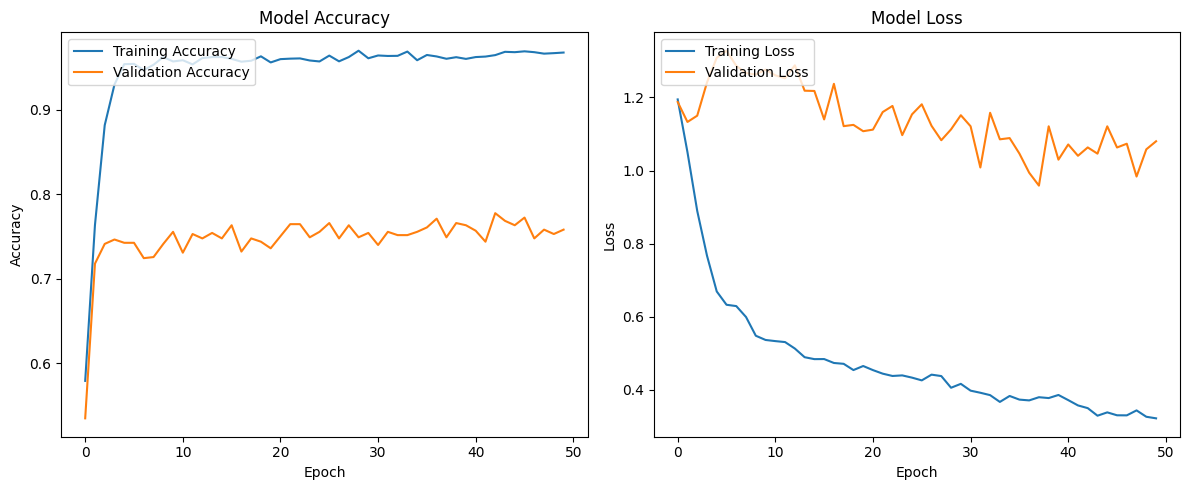

In [25]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
# Show the plots
plt.tight_layout()
plt.show()

In [26]:
model.save("Sentimental analysis model.h5")

C:\Users\Moatsem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
# Function to make sentiment prediction
def predict_sentiment(user_input):
    # Preprocess the input text
    processed_text = preprocess_text(user_input)

    # Transform input text using the loaded vectorizer
    input_vector = vectorizer.transform([processed_text])

    # Make prediction (sigmoid output will be between 0 and 1)
    prediction = model.predict(input_vector.toarray())

    # Return sentiment based on prediction threshold (e.g., 0.5)
    if prediction >= 0.5:
        return "Positive sentiment"
    else:
        return "Negative sentiment"

In [27]:
# Function to handle prediction
def predict():
    user_input = text_input.get("1.0", tk.END).strip()
    sentiment = predict_sentiment(user_input)
    result_label.config(text=f"Predicted sentiment: {sentiment}")

In [31]:
# Create the main window
root = tk.Tk()
root.title("Sentiment Analysis GUI")

# Create a text input field
text_input = tk.Text(root, height=10, width=40)
text_input.pack(padx=10, pady=10)

# Create a button to trigger prediction
predict_button = ttk.Button(root, text="Predict Sentiment", command=predict)
predict_button.pack(padx=10, pady=10)

# Create a label to display the result
result_label = tk.Label(root, text="")
result_label.pack(padx=10, pady=10)

# Start the main loop
root.mainloop()

1/1 [==============================] - 0s 89ms/step
